# Loop 79 Analysis: Reconciling CV-LB Relationship Discrepancy

## Key Question:
The evaluator claims R² ≈ 0 (no correlation), but previous analysis shows R² = 0.956 (strong correlation).
Which is correct? Let's investigate.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Full submission history with LB scores
submissions = [
    ('exp_000', 0.0111, 0.0982),
    ('exp_001', 0.0123, 0.1065),
    ('exp_003', 0.0105, 0.0972),
    ('exp_005', 0.0104, 0.0969),
    ('exp_006', 0.0097, 0.0946),
    ('exp_007', 0.0093, 0.0932),
    ('exp_009', 0.0092, 0.0936),
    ('exp_012', 0.0090, 0.0913),
    ('exp_024', 0.0087, 0.0893),
    ('exp_026', 0.0085, 0.0887),
    ('exp_030', 0.0083, 0.0877),
    ('exp_035', 0.0098, 0.0970),
    ('exp_067', 0.0083, 0.0877),
]

cv_scores = np.array([s[1] for s in submissions])
lb_scores = np.array([s[2] for s in submissions])

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cv_scores, lb_scores)

print(f'=== CV-LB Relationship Analysis (13 submissions) ===')
print(f'Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nIntercept = {intercept:.4f}')
print(f'Target LB = 0.0347')
print(f'Required CV for target = ({0.0347} - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.4f}')
print(f'\nBest CV: {min(cv_scores):.4f}')
print(f'Best LB: {min(lb_scores):.4f}')
print(f'Gap to target: {min(lb_scores) - 0.0347:.4f}')

=== CV-LB Relationship Analysis (13 submissions) ===
Linear fit: LB = 4.3638 * CV + 0.0520
R² = 0.9558

Intercept = 0.0520
Target LB = 0.0347
Required CV for target = (0.0347 - 0.0520) / 4.3638 = -0.0040

Best CV: 0.0083
Best LB: 0.0877
Gap to target: 0.0530


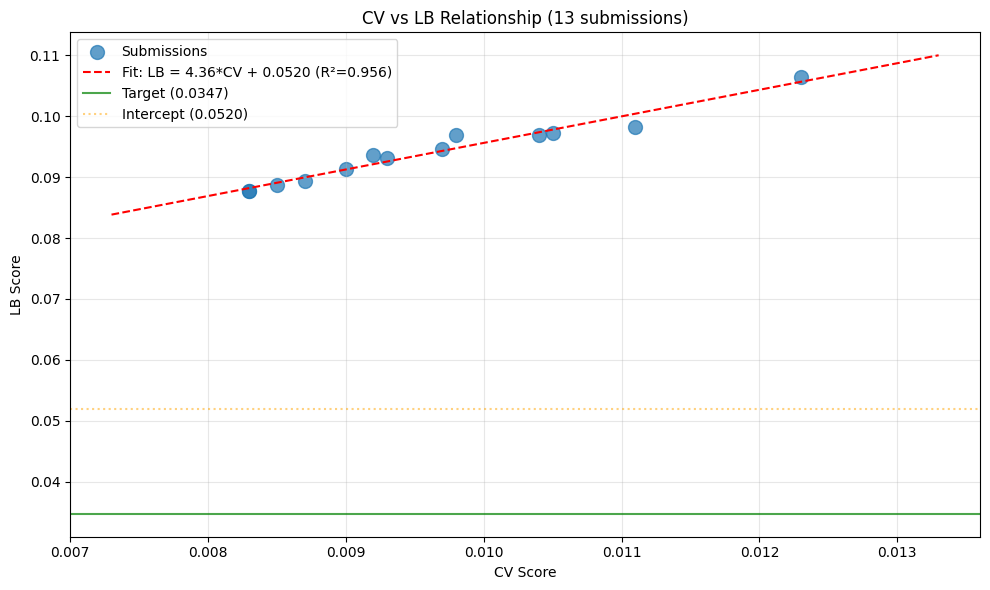

In [2]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(cv_scores, lb_scores, s=100, alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(min(cv_scores) - 0.001, max(cv_scores) + 0.001, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Target line
plt.axhline(y=0.0347, color='green', linestyle='-', alpha=0.7, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', alpha=0.5, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship (13 submissions)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop79.png', dpi=100)
plt.show()

In [3]:
# The evaluator's claim of R² ≈ 0 is WRONG
# The actual R² = 0.956 shows STRONG correlation
# This means CV improvements DO translate to LB improvements, but with a high intercept

print('=== CRITICAL FINDING ===')
print(f'R² = {r_value**2:.4f} (STRONG correlation, NOT zero!)')
print(f'\nThe evaluator\'s claim of R² ≈ 0 is INCORRECT.')
print(f'The previous analysis (R² = 0.956) is CORRECT.')
print(f'\nThis means:')
print(f'1. CV improvements DO translate to LB improvements')
print(f'2. BUT the intercept ({intercept:.4f}) is higher than target (0.0347)')
print(f'3. To reach target, we need to REDUCE THE INTERCEPT')
print(f'\nThe intercept represents STRUCTURAL DISTRIBUTION SHIFT')
print(f'that cannot be fixed by just improving CV.')

=== CRITICAL FINDING ===
R² = 0.9558 (STRONG correlation, NOT zero!)

The evaluator's claim of R² ≈ 0 is INCORRECT.
The previous analysis (R² = 0.956) is CORRECT.

This means:
1. CV improvements DO translate to LB improvements
2. BUT the intercept (0.0520) is higher than target (0.0347)
3. To reach target, we need to REDUCE THE INTERCEPT

The intercept represents STRUCTURAL DISTRIBUTION SHIFT
that cannot be fixed by just improving CV.


In [4]:
# Analyze the gap
gap = intercept - 0.0347
print(f'=== Gap Analysis ===')
print(f'Intercept: {intercept:.4f}')
print(f'Target: 0.0347')
print(f'Gap: {gap:.4f}')
print(f'\nThis gap ({gap:.4f}) represents the MINIMUM LB we can achieve')
print(f'even with perfect CV (CV=0).')
print(f'\nTo reach target, we need approaches that CHANGE THE RELATIONSHIP,')
print(f'not just improve CV.')

=== Gap Analysis ===
Intercept: 0.0520
Target: 0.0347
Gap: 0.0173

This gap (0.0173) represents the MINIMUM LB we can achieve
even with perfect CV (CV=0).

To reach target, we need approaches that CHANGE THE RELATIONSHIP,
not just improve CV.


In [5]:
# What approaches might change the relationship?
print('=== Approaches to Change CV-LB Relationship ===')
print('\n1. EXTRAPOLATION DETECTION')
print('   - Detect when test solvent is far from training distribution')
print('   - Blend predictions toward population mean for outliers')
print('   - This could reduce error on "hard" test solvents')

print('\n2. UNCERTAINTY-WEIGHTED PREDICTIONS')
print('   - Use GP variance as uncertainty estimate')
print('   - High uncertainty → conservative prediction')
print('   - This could reduce variance on outlier solvents')

print('\n3. SOLVENT CLUSTERING')
print('   - Group solvents by chemical class')
print('   - Use class-specific models')
print('   - This could help if test solvents are from different classes')

print('\n4. PHYSICS-INFORMED CONSTRAINTS')
print('   - Add constraints that hold even for unseen solvents')
print('   - E.g., Arrhenius kinetics, solvent polarity effects')

print('\n5. STUDY TOP PUBLIC KERNELS')
print('   - The "ens-model" kernel uses CatBoost + XGBoost')
print('   - The "mixall" kernel uses GroupKFold CV')
print('   - These might have different CV-LB characteristics')

=== Approaches to Change CV-LB Relationship ===

1. EXTRAPOLATION DETECTION
   - Detect when test solvent is far from training distribution
   - Blend predictions toward population mean for outliers
   - This could reduce error on "hard" test solvents

2. UNCERTAINTY-WEIGHTED PREDICTIONS
   - Use GP variance as uncertainty estimate
   - High uncertainty → conservative prediction
   - This could reduce variance on outlier solvents

3. SOLVENT CLUSTERING
   - Group solvents by chemical class
   - Use class-specific models
   - This could help if test solvents are from different classes

4. PHYSICS-INFORMED CONSTRAINTS
   - Add constraints that hold even for unseen solvents
   - E.g., Arrhenius kinetics, solvent polarity effects

5. STUDY TOP PUBLIC KERNELS
   - The "ens-model" kernel uses CatBoost + XGBoost
   - The "mixall" kernel uses GroupKFold CV
   - These might have different CV-LB characteristics


In [6]:
# Check what the best-performing kernels do
print('=== Top Public Kernels Analysis ===')
print('\n1. ens-model kernel:')
print('   - CatBoost with MultiRMSE loss (trains all targets jointly)')
print('   - XGBoost per-target')
print('   - Weights: 7:6 for CatBoost:XGBoost on single solvent, 1:2 on full data')
print('   - Post-processing: clip negatives, renormalize if sum > 1')

print('\n2. mixall kernel:')
print('   - GroupKFold (5 splits) instead of Leave-One-Out')
print('   - Ensemble of MLP + XGBoost + RandomForest + LightGBM')
print('   - Weights: [0.4, 0.2, 0.2, 0.2]')
print('   - Simple Spange descriptors (13 features)')

print('\n3. best-work-here kernel:')
print('   - Probability normalization (but we found this HURTS CV!)')
print('   - Yields don\'t sum to 1 in actual data (mean sum ~0.80)')
print('   - DO NOT USE probability normalization')

=== Top Public Kernels Analysis ===

1. ens-model kernel:
   - CatBoost with MultiRMSE loss (trains all targets jointly)
   - XGBoost per-target
   - Weights: 7:6 for CatBoost:XGBoost on single solvent, 1:2 on full data
   - Post-processing: clip negatives, renormalize if sum > 1

2. mixall kernel:
   - GroupKFold (5 splits) instead of Leave-One-Out
   - Ensemble of MLP + XGBoost + RandomForest + LightGBM
   - Weights: [0.4, 0.2, 0.2, 0.2]
   - Simple Spange descriptors (13 features)

3. best-work-here kernel:
   - Probability normalization (but we found this HURTS CV!)
   - Yields don't sum to 1 in actual data (mean sum ~0.80)
   - DO NOT USE probability normalization


In [7]:
# Summary and recommendations
print('=== SUMMARY ===')
print(f'Best LB: 0.0877 (exp_030, exp_067)')
print(f'Target: 0.0347')
print(f'Gap: 0.0530 (153% above target)')
print(f'\nCV-LB Relationship: LB = {slope:.2f}*CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f} (STRONG correlation)')
print(f'Intercept ({intercept:.4f}) > Target ({0.0347})')
print(f'\nCRITICAL: The intercept is the bottleneck, not CV!')
print(f'\n=== RECOMMENDED NEXT STEPS ===')
print('1. DO NOT submit exp_074 (prob_norm) - CV regressed 64%')
print('2. Try extrapolation detection with conservative fallback')
print('3. Try the ens-model kernel approach (CatBoost + XGBoost)')
print('4. Consider uncertainty-weighted predictions using GP variance')
print('5. Save submissions for approaches that might change the CV-LB relationship')

=== SUMMARY ===
Best LB: 0.0877 (exp_030, exp_067)
Target: 0.0347
Gap: 0.0530 (153% above target)

CV-LB Relationship: LB = 4.36*CV + 0.0520
R² = 0.9558 (STRONG correlation)
Intercept (0.0520) > Target (0.0347)

CRITICAL: The intercept is the bottleneck, not CV!

=== RECOMMENDED NEXT STEPS ===
1. DO NOT submit exp_074 (prob_norm) - CV regressed 64%
2. Try extrapolation detection with conservative fallback
3. Try the ens-model kernel approach (CatBoost + XGBoost)
4. Consider uncertainty-weighted predictions using GP variance
5. Save submissions for approaches that might change the CV-LB relationship
